In [3]:
XLA_PYTHON_CLIENT_MEM_FRACTION=.5

#import wandb

import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random, jit

from scipy.special import comb

from jax.numpy.linalg import det
import jax

import matplotlib
#matplotlib.rcParams.update({'font.size': 12})


In [193]:

def cumsum2(x,axis=0):
    return jnp.cumsum(x,axis=axis)-x

def getfun(X0,X1,kmax):
    P=jnp.shape(X0)[0]
    Q=jnp.shape(X0)[1]
    
    idcs = jnp.tile(jnp.arange(P)[:, None], (1, Q))

    def compute_m_one(i):
        S = P * jnp.where(idcs == i, X0, 0)
        X0sub = jnp.where(idcs >= i, X0, 0)
        X1sub = jnp.where(idcs >= i, X1, 0)
        m_one = []
        for k in jnp.arange(kmax-1) + 1:
            S = ((k + 1) ** 2) / ((P - k) * (Q - k)) * cumsum2(cumsum2(S, axis=0) * X1sub, axis=1) * X0sub
            m_one.append(jnp.sum((jnp.sum(S, axis=0) / P) * X1[i, :]) / Q)
        return jnp.array(m_one)
    
    return compute_m_one



def momest(X0,X1,kmax=5,reps=3):
    P=jnp.shape(X0)[0]
    Q=jnp.shape(X0)[1]
    
    
    key = random.PRNGKey(0)
    Mvs2=[]
    for u in range(reps):
        key1,key2,key = random.split(key,3)
        X0_new=random.permutation(key2,random.permutation(key1, X0, axis=0),axis=1)
        X1_new=random.permutation(key2,random.permutation(key1, X1, axis=0),axis=1)
        compute_m_one = getfun(X0_new,X1_new,kmax)
        # Vectorize the computation across the first dimension
        compute_m_one_vmap = jax.vmap(compute_m_one, in_axes=(0,))
        Ms = compute_m_one_vmap(jnp.arange(P))
        Ms0 = jnp.sum(Ms, axis=0) / P
        Mvs2.append(np.squeeze(Ms0))    
    mv2=np.mean(np.array(Mvs2),axis=0)
    
    return mv2

def compute_RBF_m(k, Sigma, Sigma_x):
    # Identity matrix of the same shape as Sigma
    I = jnp.eye(Sigma.shape[0])
    
    # Inverse of Sigma
    Sigma_inv = jnp.linalg.inv(Sigma)
    
    # Initialize the product
    prod_determinants = 1.0

    # Loop over q from 0 to k-1
    for q in range(k):
        # Calculate the exponent term
        #exponent_term = 2 * (1 - jnp.exp(2j * jnp.pi * q / k))
        exponent_term = 2 * (1 - jnp.cos(2 * jnp.pi * q / k))

        # Compute the matrix inside the determinant
        matrix_term = exponent_term * Sigma_inv @ Sigma_x + I
        
        # Calculate the determinant
        det_value = det(matrix_term)
        
        # Multiply to the product of determinants
        prod_determinants *= det_value
    
    # Compute m(k) as the product raised to the power of -1/2
    m_k = prod_determinants ** (-0.5)
    
    return m_k

def getKong(Xs1,Xs2,k):
    P=jnp.shape(Xs1)[0]
    Q=jnp.shape(Xs1)[1]
    
    Kc = jnp.matmul(Xs1,Xs2.T)/Q
    KongEst = jnp.trace(jnp.matmul(jnp.linalg.matrix_power(jnp.triu(Kc, 1),int(k-1)),Kc))/comb(P,k)
    return KongEst

def conv(x,m=20):
    n=jnp.shape(x)[1]
    A=jnp.tile(jnp.arange(n),(n,1))
    C=(jnp.abs(A-A.T)<=int(m/2))*1/jnp.sqrt(m+1)
    return jnp.matmul(x,C)

def detRBFData(d,sigmax,sigma,P,Q,key,eps0=0,eps1=0):
    sqrt2=jnp.sqrt(2)
    key1,key2,key3, key = random.split(key,4)
    
    #X=np.random.randn(P,d)*sigmax
    X=random.normal(key1, (P, d))*sigmax
    W=random.normal(key2, (d, Q))/sigma

    p=random.uniform(key3,(Q,),minval=-jnp.pi/2,maxval=jnp.pi/2)

    Phi=sqrt2*jnp.cos(jnp.matmul(X,W)-p[None,:])
    
    if eps0!=0:
        key1,key2,key = random.split(key,3)
        Psi1=random.normal(key1, (P, Q))*eps0
        Psi2=random.normal(key2, (P, Q))*eps0
    else:
        Psi1=0
        Psi2=0
    
    if eps1!=0:
        key1,key2,key = random.split(key,3)
        Psi1a=conv(random.normal(key1, (P, Q))*eps1, m=10)
        Psi2a=conv(random.normal(key2, (P, Q))*eps1, m=10)
    else:
        Psi1a=0
        Psi2a=0
    
    Theta1=Phi+Psi1+Psi1a
    Theta2=Phi+Psi2+Psi2a
    return Theta1,Theta2,key

def getKsTerms(Xs1,Xs2,M=jnp.inf,F=jnp.inf):
    P=jnp.shape(Xs1)[0]
    Q=jnp.shape(Xs1)[1]
    
    Phr=(P-1)/(M-1)
    Qhr=(Q-1)/(F-1)
    Pr=P/M
    Qr=Q/F
    
    #if False:
    if P<Q:
        Kv=1/Q*jnp.matmul(Xs1,Xs2.T)
        nTrKs_min2=jnp.mean(jnp.diag(jnp.linalg.matrix_power(Kv,2)/P))
        #nTrKs_min2=jnp.mean(jnp.square(1/Q*jnp.matmul(Xs1,Xs2.T)))
    else:
        Kv=1/P*jnp.matmul(Xs1.T,Xs2)
        nTrKs_min2=jnp.mean(jnp.diag(jnp.linalg.matrix_power(Kv,2)/Q))
        #nTrKs_min2=jnp.mean(jnp.square(1/P*jnp.matmul(Xs1.T,Xs2)))
            
    Term2=-(1-Phr)/P * jnp.mean(jnp.square(jnp.mean(Xs1*Xs2,axis=1)))
    Term3=-(1-Qhr)/Q * jnp.mean(jnp.square(jnp.mean(Xs1*Xs2,axis=0)))
    Term4=((1-Phr)*(1-Qhr))/(P*Q) * jnp.mean(jnp.power(Xs1*Xs2,2))
        
    v =  Term2 + Term3 + Term4
    
    nsTrKs = jnp.square(jnp.mean(Xs1*Xs2))
    
    # if M and F are infinite, or even if M and F are finite:
    denom =  (nTrKs_min2 +v)
    numer =  (nsTrKs +v)
    # There are some scaling differences, but all that matters is numer/denom, which cancels out the scaling factors.
    
    gammas=nsTrKs/nTrKs_min2
    gamma_mp1=gammas*P/(P-gammas)
    gamma_mp2=gammas*Q/(Q-gammas)
    
    return numer , denom , gammas, gamma_mp1,gamma_mp2



In [210]:


def run_exp(P,Q,d,sigma,sigmax,eps_a,eps_m,kmax,key,noAlt,reps=10):
    X0,X1,key = detRBFData(d,sigmax,sigma,P,Q,key,eps0=eps_m,eps1=eps_a)
    if noAlt:
        X1=X0
    mds = momest(X0,X1,kmax=kmax,reps=reps)

    s,_=jnp.linalg.eigh(jnp.matmul(X0,X1.T)/Q)
    mns=[]
    mk0s=[]
    mk1s=[]
    for k in jnp.arange(1,kmax)+1:
        mns.append(jnp.sum(jnp.power(s/P,k)))
        mk0s.append(getKong(X0,X1,k))
        mk1s.append(getKong(X0.T,X1.T,k))
        
    numer , denom ,gammas, _,_ = getKsTerms(X0,X1,M=jnp.inf,F=jnp.inf)
    
    return mds.tolist(),mns,mk0s,mk1s,numer,denom,gammas, key
            
def run_repeats(P,Q,d,sigma,sigmax,eps_a,eps_m,kmax,seed,numit,noAlt,reps=10):
    key = random.PRNGKey(seed)
    Mss=[]
    Mk0s=[]
    Mk1s=[]
    Mns=[]
    numers=[]
    denoms=[]
    gammass=[]
    for it in range(numit):
        print('\r{:.2f}'.format((it+1)/numit),end='')
        mds,mns,mk0s,mk1s,numer,denom,gammas,key=run_exp(P,Q,d,sigma,sigmax,eps_a,eps_m,kmax,key,noAlt,reps=reps)
        
        #for md,mn,mk0,mk1 in zip(mds,mns,mk0s,mk1s):
            #print(md)
            #wandb.log({"double": md, "single_row": mk0, "single_col": mk1, "naive":mn})
            
        #wandb.finish()

        Mss.append(mds)
        Mns.append(mns)
        Mk0s.append(mk0s)
        Mk1s.append(mk1s)
        
        gammass.append(gammas)
        numers.append(numer)
        denoms.append(denom)
    Mss=np.array(Mss).T
    Mns=np.array(Mns).T
    Mk0s=np.array(Mk0s).T
    Mk1s=np.array(Mk1s).T
    
    dimest=np.mean(numers)/np.mean(denoms)
    return Mss,Mns,Mk0s,Mk1s,dimest,np.mean(gammass)


kmax=7
seed=1
numit=10000
sigmax=1

casen=9

if casen==1:
    P=300
    Q=600
    sigma=0.5
    d=5
    eps_ind=0
    eps_cor=0
    noAlt=True
elif casen==2:
    P=300
    Q=600
    sigma=1
    d=10
    eps_ind=0
    eps_cor=0
    noAlt=True
elif casen==3:
    P=30
    Q=60
    sigma=2
    d=10
    eps_ind=0
    eps_cor=0
    noAlt=True
elif casen==4:
    P=30
    Q=60
    sigma=0.5
    d=2
    eps_ind=0
    eps_cor=0
    noAlt=True
    
elif casen>=5:
    P=75
    Q=150
    sigma=0.5
    d=3
    
    #P=300
    #Q=600
    #sigma=0.5
    #d=5
    noise_scale=1
    if casen==5:
        eps_ind=0
        eps_cor=0   
        noAlt=True
    elif casen==6:
        eps_ind=noise_scale
        eps_cor=0   
        noAlt=True
    elif casen==7:
        eps_ind=0
        eps_cor=noise_scale
        noAlt=True
    elif casen==8:
        eps_ind=noise_scale
        eps_cor=0   
        noAlt=False
    elif casen==9:
        eps_ind=0
        eps_cor=noise_scale
        noAlt=False

Mss,Mns,Mk0s,Mk1s,dimest,gams = run_repeats(P,Q,d,sigma,sigmax,eps_cor,eps_ind,kmax,seed,numit,noAlt,reps=1)

Sigma_x=jnp.eye(d)*sigmax**2
Sigma=jnp.eye(d)*sigma**2

Mts=[]
for k in np.arange(1,kmax)+1:
    Mts.append(compute_RBF_m(k, Sigma, Sigma_x))

#np.savez('./sweep_data/'+'s_d{}_s{}_p{}_q{}_a{}_m{}_n{}.npz'.format(d,sigma,P,Q,eps_a,eps_m,noa), Mss=Mss,Mns=Mns,Mk0s=Mk0s,Mk1s=Mk1s,Mts=Mts,dimest=dimest,gams=gams,kmax=kmax,seed=seed,numit=numit,sigmax=sigmax)


Mts=np.array(Mts)



1.00

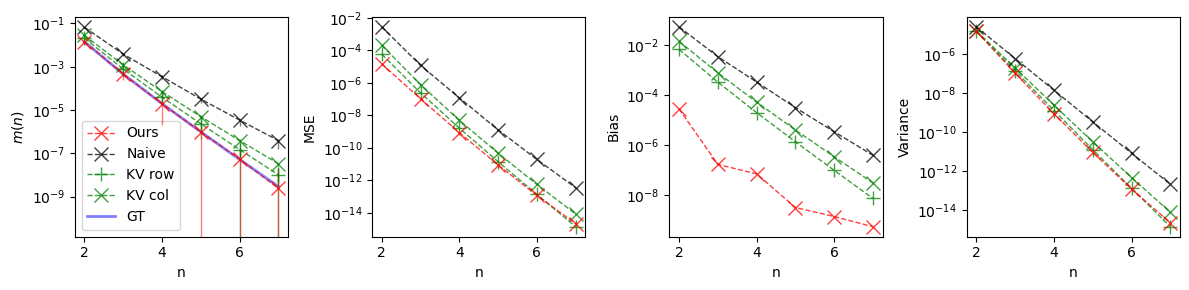

In [211]:
ylog=True
ls='--'
eb_alpha=0.5

fig,ax=plt.subplots(1,4,figsize=(12,3))
#ax.plot(Ps,gims,c='k',label='theory')

xoi=np.arange(kmax-1)+2
qoi=Mss
colorv='r'
zo=10
yval=np.nanmedian(qoi,axis=1)
lower_error=np.nanquantile(qoi,axis=1,q=0.25)
upper_error=np.nanquantile(qoi,axis=1,q=0.75)
asymmetric_error = [yval-lower_error, upper_error-yval]
ax[0].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=eb_alpha,lw=1,zorder=zo)#, fmt='o')
yval=np.nanmean(qoi,axis=1)
ax[0].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Ours',zorder=zo*100)#, fmt='o')


qoi=Mns
colorv='k'
zo=5
yval=np.nanmedian(qoi,axis=1)
lower_error=np.nanquantile(qoi,axis=1,q=0.25)
upper_error=np.nanquantile(qoi,axis=1,q=0.75)
asymmetric_error = [yval-lower_error, upper_error-yval]
ax[0].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=eb_alpha,lw=1,zorder=zo)#, fmt='o')
yval=np.nanmean(qoi,axis=1)
ax[0].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Naive',zorder=zo*100)#, fmt='o')


qoi=Mk0s
colorv='g'
zo=1
yval=np.nanmedian(qoi,axis=1)
lower_error=np.nanquantile(qoi,axis=1,q=0.25)
upper_error=np.nanquantile(qoi,axis=1,q=0.75)
asymmetric_error = [yval-lower_error, upper_error-yval]
ax[0].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=eb_alpha,lw=1,zorder=zo)#, fmt='o')
yval=np.nanmean(qoi,axis=1)
ax[0].plot(xoi, yval,c=colorv,marker='+',ls=ls,alpha=0.75,ms=10,lw=1,label=r'KV row',zorder=zo*100)#, fmt='o')



qoi=Mk1s
colorv='g'
zo=1
yval=np.nanmedian(qoi,axis=1)
lower_error=np.nanquantile(qoi,axis=1,q=0.25)
upper_error=np.nanquantile(qoi,axis=1,q=0.75)
asymmetric_error = [yval-lower_error, upper_error-yval]
ax[0].errorbar(xoi, yval, yerr=asymmetric_error,c=colorv,marker='',ls='',alpha=eb_alpha,lw=1,zorder=zo)#, fmt='o')
yval=np.nanmean(qoi,axis=1)
ax[0].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'KV col',zorder=zo*100)#, fmt='o')

zo=-1
ax[0].plot(xoi,np.array(Mts),c='b',lw=2,alpha=0.5,label='GT',zorder=zo)

#ax.set_xscale('log')
ax[0].set_xlabel('n')
ax[0].set_ylabel(r'$m(n)$')
#ax.set_title('N={}, Q={}'.format(N,Q),fontsize=11)



gt=np.array(Mts)

#fig,ax=plt.subplots(1,3,figsize=(12,4))
#ax.plot(Ps,gims,c='k',label='theory')

xoi=np.arange(kmax-1)+2
qoi=Mss
yval=np.nanmean(np.square(gt[:,None]-qoi),axis=1)
colorv='r'
zo=10
ax[1].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Ours',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mns
yval=np.nanmean(np.square(gt[:,None]-qoi),axis=1)
colorv='k'
zo=5
ax[1].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Naive',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mk0s
yval=np.nanmean(np.square(gt[:,None]-qoi),axis=1)
colorv='g'
zo=1
ax[1].plot(xoi, yval,c=colorv,marker='+',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Kong row',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mk1s
yval=np.nanmean(np.square(gt[:,None]-qoi),axis=1)
colorv='g'
zo=1
ax[1].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Kong col',zorder=zo*100)#, fmt='o')



#ax.set_xscale('log')
ax[1].set_xlabel('n')
ax[1].set_ylabel('MSE')
#ax[1].legend(fontsize=11)
#ax.set_title('N={}, Q={}'.format(N,Q),fontsize=11)




xoi=np.arange(kmax-1)+2
qoi=Mss
yval=np.abs(gt-np.nanmean(qoi,axis=1))
colorv='r'
zo=10
ax[2].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Ours',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mns
yval=np.abs(gt-np.nanmean(qoi,axis=1))
colorv='k'
zo=5
ax[2].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Naive',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mk0s
yval=np.abs(gt-np.nanmean(qoi,axis=1))
colorv='g'
zo=1
ax[2].plot(xoi, yval,c=colorv,marker='+',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Kong row',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mk1s
yval=np.abs(gt-np.nanmean(qoi,axis=1))
colorv='g'
zo=1
ax[2].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Kong col',zorder=zo*100)#, fmt='o')

#ax.set_xscale('log')
ax[2].set_xlabel('n')
ax[2].set_ylabel('Bias')
#ax[1].legend(fontsize=11)
#ax.set_title('N={}, Q={}'.format(N,Q),fontsize=11)



#ax.plot(Ps,gims,c='k',label='theory')

xoi=np.arange(kmax-1)+2
qoi=Mss
yval=np.square(np.nanstd(qoi,axis=1))
colorv='r'
zo=10
ax[3].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Ours',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mns
yval=np.square(np.nanstd(qoi,axis=1))
colorv='k'
zo=5
ax[3].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'Naive',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mk0s
yval=np.square(np.nanstd(qoi,axis=1))
colorv='g'
zo=1
ax[3].plot(xoi, yval,c=colorv,marker='+',ls=ls,alpha=0.75,ms=10,lw=1,label=r'KV row',zorder=zo*100)#, fmt='o')

xoi=np.arange(kmax-1)+2
qoi=Mk1s
yval=np.square(np.nanstd(qoi,axis=1))
colorv='g'
zo=1
ax[3].plot(xoi, yval,c=colorv,marker='x',ls=ls,alpha=0.75,ms=10,lw=1,label=r'KV col',zorder=zo*100)#, fmt='o')

#ax.set_xscale('log')
ax[3].set_xlabel('n')
ax[3].set_ylabel('Variance')
#ax[2].legend(fontsize=11)
#ax.set_title('N={}, Q={}'.format(N,Q),fontsize=11)


if ylog:
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    ax[2].set_yscale('log')
    ax[3].set_yscale('log')


ax[0].legend(fontsize=10).set_zorder(-100000)
    
fig.tight_layout()

#fig

# for the bias: try \hat{m}(n)-GT with the error bars.



In [212]:
np.savez('RBF_plot_data_sup_BV_{}.npz'.format(casen), 
         kmax=kmax, seed=seed, sigmax=sigmax, 
         P=P, Q=Q, sigma=sigma, d=d, eps_ind=eps_ind, eps_cor=eps_cor, noAlt=noAlt,
         Mss=Mss, Mns=Mns, Mk0s=Mk0s, Mk1s=Mk1s,
         Mts=Mts)


In [213]:


def run_exp(P,Q,d,sigma,sigmax,eps_a,eps_m,kmax,key,noAlt,reps=10):
    X0,X1,key = detRBFData(d,sigmax,sigma,P,Q,key,eps0=eps_m,eps1=eps_a)
    if noAlt:
        X1=X0
    mds = momest(X0,X1,kmax=kmax,reps=reps)

    s,_=jnp.linalg.eigh(jnp.matmul(X0,X1.T)/Q)
    mns=[]
    mk0s=[]
    mk1s=[]
    for k in jnp.arange(1,kmax)+1:
        mns.append(jnp.sum(jnp.power(s/P,k)))
        mk0s.append(getKong(X0,X1,k))
        mk1s.append(getKong(X0.T,X1.T,k))
        
    numer , denom ,gammas, _,_ = getKsTerms(X0,X1,M=jnp.inf,F=jnp.inf)
    
    return mds.tolist(),mns,mk0s,mk1s,numer,denom,gammas, key
            
def run_repeats(P,Q,d,sigma,sigmax,eps_a,eps_m,kmax,seed,numit,noAlt,reps=10):
    key = random.PRNGKey(seed)
    Mss=[]
    Mk0s=[]
    Mk1s=[]
    Mns=[]
    numers=[]
    denoms=[]
    gammass=[]
    for it in range(numit):
        print('\r{:.2f}'.format((it+1)/numit),end='')
        mds,mns,mk0s,mk1s,numer,denom,gammas,key=run_exp(P,Q,d,sigma,sigmax,eps_a,eps_m,kmax,key,noAlt,reps=reps)
        
        #for md,mn,mk0,mk1 in zip(mds,mns,mk0s,mk1s):
            #print(md)
            #wandb.log({"double": md, "single_row": mk0, "single_col": mk1, "naive":mn})
            
        #wandb.finish()

        Mss.append(mds)
        Mns.append(mns)
        Mk0s.append(mk0s)
        Mk1s.append(mk1s)
        
        gammass.append(gammas)
        numers.append(numer)
        denoms.append(denom)
    Mss=np.array(Mss).T
    Mns=np.array(Mns).T
    Mk0s=np.array(Mk0s).T
    Mk1s=np.array(Mk1s).T
    
    dimest=np.mean(numers)/np.mean(denoms)
    return Mss,Mns,Mk0s,Mk1s,dimest,np.mean(gammass)


kmax=7
seed=1
numit=10000
sigmax=1

for casen in [5,6,7,8,9]:
#casen=9

    if casen==1:
        P=300
        Q=600
        sigma=0.5
        d=5
        eps_ind=0
        eps_cor=0
        noAlt=True
    elif casen==2:
        P=300
        Q=600
        sigma=1
        d=10
        eps_ind=0
        eps_cor=0
        noAlt=True
    elif casen==3:
        P=30
        Q=60
        sigma=2
        d=10
        eps_ind=0
        eps_cor=0
        noAlt=True
    elif casen==4:
        P=30
        Q=60
        sigma=0.5
        d=2
        eps_ind=0
        eps_cor=0
        noAlt=True

    elif casen>=5:
        P=75
        Q=150
        sigma=0.5
        d=3

        #P=300
        #Q=600
        #sigma=0.5
        #d=5
        noise_scale=1
        if casen==5:
            eps_ind=0
            eps_cor=0   
            noAlt=True
        elif casen==6:
            eps_ind=noise_scale
            eps_cor=0   
            noAlt=True
        elif casen==7:
            eps_ind=0
            eps_cor=noise_scale
            noAlt=True
        elif casen==8:
            eps_ind=noise_scale
            eps_cor=0   
            noAlt=False
        elif casen==9:
            eps_ind=0
            eps_cor=noise_scale
            noAlt=False

    Mss,Mns,Mk0s,Mk1s,dimest,gams = run_repeats(P,Q,d,sigma,sigmax,eps_cor,eps_ind,kmax,seed,numit,noAlt,reps=1)

    Sigma_x=jnp.eye(d)*sigmax**2
    Sigma=jnp.eye(d)*sigma**2

    Mts=[]
    for k in np.arange(1,kmax)+1:
        Mts.append(compute_RBF_m(k, Sigma, Sigma_x))

    #np.savez('./sweep_data/'+'s_d{}_s{}_p{}_q{}_a{}_m{}_n{}.npz'.format(d,sigma,P,Q,eps_a,eps_m,noa), Mss=Mss,Mns=Mns,Mk0s=Mk0s,Mk1s=Mk1s,Mts=Mts,dimest=dimest,gams=gams,kmax=kmax,seed=seed,numit=numit,sigmax=sigmax)


    Mts=np.array(Mts)


    np.savez('RBF_plot_data_sup_BV_{}.npz'.format(casen), 
             kmax=kmax, seed=seed, sigmax=sigmax, 
             P=P, Q=Q, sigma=sigma, d=d, eps_ind=eps_ind, eps_cor=eps_cor, noAlt=noAlt,
             Mss=Mss, Mns=Mns, Mk0s=Mk0s, Mk1s=Mk1s,
             Mts=Mts)




1.00